In [52]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ttvfast import models, ttvfast

Tstart=1500
Tend=4000

def calc_ttvs_full(p):
    mp1, sqecosw1, sqesinw1, wpn1, P1 = p[3], p[4], p[5], p[6], p[7]
    mp2, sqecosw2, sqesinw2, wpn2, P2 = p[10], p[11], p[12], p[13], p[14]
    e1, e2 = sqecosw1**2 + sqesinw1**2, sqecosw2**2 + sqesinw2**2
    w1, w2 = np.arctan2(sqesinw1, sqecosw1), np.arctan2(sqesinw2, sqecosw2)
    n1, n2 = (wpn1 - w1) % (2 * np.pi), (wpn2 - w2) % (2 * np.pi)

    gravity, stellar_mass = 0.000295994511, 0.73
    planet1 = models.Planet(mp1 / 332946., P1, e1, 90, 180, np.rad2deg(w1), np.rad2deg(n1))
    planet2 = models.Planet(mp2 / 332946., P2, e2, 90, 180, np.rad2deg(w2), np.rad2deg(n2))
    results = ttvfast([planet1, planet2], stellar_mass, Tstart, 0.1, Tend)

    pl, model_epoch, model_tt, model_vsky = map(np.array, [results['positions'][0], results['positions'][1], results['positions'][2], results['positions'][4]])
    pl1_index, pl2_index = np.where((pl == 0) & (model_vsky > 0))[0], np.where((pl == 1) & (model_vsky > 0))[0]
    model_epoch1, model_tt1 = model_epoch[pl1_index], model_tt[pl1_index]
    model_epoch2, model_tt2 = model_epoch[pl2_index], model_tt[pl2_index]

    def linear_regression(X, y):
        regressor = LinearRegression().fit(X.reshape(-1, 1), y)
        residuals = y - regressor.predict(X.reshape(-1, 1))
        return residuals, regressor.coef_

    residuals_tt1, P1 = linear_regression(model_epoch1, model_tt1)
    residuals_tt2, P2 = linear_regression(model_epoch2, model_tt2)
    return model_epoch1, model_epoch2, model_tt1, model_tt2, residuals_tt1, residuals_tt2, P1, P2
'''
# best_fitにしたほうがいいかもという話はある
print(calc_ttvs_full([ 1.51162896e+01 , 5.79202340e-01,  3.79384488e-02,  5.57293771e+01,
 -6.37908186e-02, -3.11231824e-02,  1.80713274e+00,  6.39725422e+00,
  1.29914132e-01 , 3.40887239e-02,  8.87393967e+01 , 1.36089686e-01,
  2.67484165e-02 , 2.58435213e+00,  1.88903925e+01 , 5.17716382e-01,
  1.37431412e-01 ,-1.43639373e+01, -1.40496996e+01 ,-1.54158431e+01,
 -1.40340617e+01 , 5.57218797e-01 , 1.34277494e+00 , 1.85678607e+00,
  1.20008366e+00  ,5.39158751e-04 , 8.87903304e-04 , 5.08726545e-04,
  4.98181664e-04]))
    mp1 = p[3]
    sqecosw1 = p[4]
    sqesinw1 = p[5]
    wpn1 = p[6] # radian
    P1 = p[7]

    mp2 = p[10]
    sqecosw2 = p[11]
    sqesinw2 = p[12]
    wpn2 = p[13] # radian
    P2 = p[14]
  '''
p=[ 1.51162896e+01 , 5.79202340e-01,  3.79384488e-02,  5.57293771e+01,
 -6.37908186e-02, -3.11231824e-02,  1.80713274e+00,  6.39725422e+00,
  1.29914132e-01 , 3.40887239e-02,  8.87393967e+01 , 1.36089686e-01,
  2.67484165e-02 , 2.58435213e+00,  1.88903925e+01 , 5.17716382e-01,
  1.37431412e-01 ,-1.43639373e+01, -1.40496996e+01 ,-1.54158431e+01,
 -1.40340617e+01 , 5.57218797e-01 , 1.34277494e+00 , 1.85678607e+00,
  1.20008366e+00  ,5.39158751e-04 , 8.87903304e-04 , 5.08726545e-04,
  4.98181664e-04]
ob_b=calc_ttvs_full(p)[2]
ob_c=calc_ttvs_full(p)[3]
ob_err_b = [0.001] * len(ob_b)
ob_err_c = [0.001] * len(ob_c)
Pb=calc_ttvs_full(p)[6]
Pc=calc_ttvs_full(p)[7]

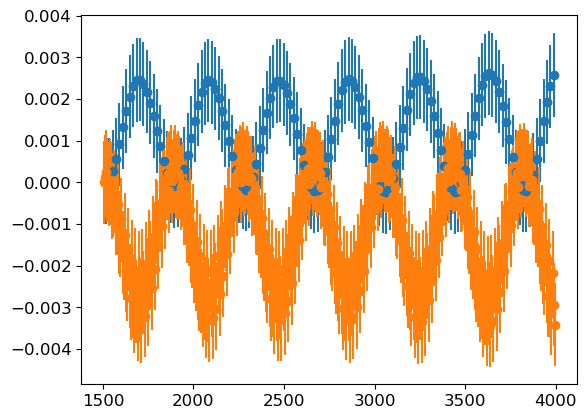

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ttvfast import models
import ttvfast
from matplotlib.ticker import AutoMinorLocator
import emcee
import corner
from multiprocessing import Pool
from scipy.optimize import minimize
import os
os.environ['OMP_NUM_THREADS']='1'
os.nice(19)

Tc0b = ob_b[0]
Tc0c = ob_c[0]

#Tstartから最初の観測までは何周期たっているか（その切り捨て）
epc0 = np.floor((Tc0c-Tstart)/Pc)
epb0 = np.floor((Tc0b-Tstart)/Pb)

#Tstartから任意の観測までは何周期たっているか（その切り捨てすなわちepoch）
epc = np.floor((ob_c-Tstart)/Pc)
epb = np.floor((ob_b-Tstart)/Pb)

#ttvの量
ttvc = ob_c - (Tc0c +(epc-epc0)*Pc)
ttvb = ob_b - (Tc0b +(epb-epb0)*Pb)
plt.errorbar(ob_c, ttvc, yerr=ob_err_c, fmt='o')
plt.errorbar(ob_b, ttvb, yerr=ob_err_b, fmt='o')

#pを渡してttvfastから得られる配列を渡す関数を定義
def calc_ttvs_2pl(p):

    mp1 = p[0]
    sqecosw1 = p[1]
    sqesinw1 = p[2]
    wpM1 = p[3] # w + M, radians,0~2*pi
    P1 = p[4]

    mp2 = p[5]
    sqecosw2 = p[6]
    sqesinw2 = p[7]
    wpM2 = p[8] # w + M, radians,0~2*pi
    P2 = p[9]
    
    #軌道要素に戻す
    e1 = sqecosw1**2 + sqesinw1**2
    e2 = sqecosw2**2 + sqesinw2**2
    w1 = np.arctan2(sqesinw1, sqecosw1) #radian,-pi~pi
    w2 = np.arctan2(sqesinw2, sqecosw2) #radian,-pi~pi
    M1 = wpM1 - w1 #radian, 幅広い値を取るが、MCMCで求める量ではないし、ttvfastには影響を与えないからこれでいい
    M2 = wpM2 - w2 #radian,

    if M1<0:
        M1+=2*np.pi
    if M1<0:
        M1+=2*np.pi
    if M2<0:
        M2+=2*np.pi
    if M2<0:
        M2+=2*np.pi
    
    gravity = 0.000295994511                        # AU^3/day^2/M_sun
    stellar_mass = 0.73                    # M_sun

    #多分これでいい
    planet1 = models.Planet(
        mass=mp1 / 332946.,                         # M_sun
        period=P1,              # days
        eccentricity=e1,
        inclination=90,         # degrees
        longnode=180,           # degrees
        argument=np.rad2deg(w1),            # degreesに変換！
        mean_anomaly= np.rad2deg(M1),       # degreesに変換！
    )

    planet2 = models.Planet(
        mass=mp2 / 332946.,
        period=P2,
        eccentricity=e2,
        inclination=90,
        longnode=180,
        argument=np.rad2deg(w2),
        mean_anomaly= np.rad2deg(M2),
    )
    

    planets = [planet1, planet2]
    dt = 0.3

    return ttvfast.ttvfast(planets, stellar_mass, Tstart, dt, Tend)

In [54]:
def log_likelihood(p):
    mp1 = p[0]
    sqecosw1 = p[1]
    sqesinw1 = p[2]
    wpM1 = p[3] # radian
    P1 = p[4]

    mp2 = p[5]
    sqecosw2 = p[6]
    sqesinw2 = p[7]
    wpM2 = p[8] # radian
    P2 = p[9]

    #あり得ない値を排除        
    if sqecosw1 <= -1. or sqecosw1 >= 1.0 or sqesinw1 <= -1. or sqesinw1 >= 1.0:
        return -np.inf
    
    if sqecosw2 <= -1. or sqecosw2 >= 1.0 or sqesinw2 <= -1. or sqesinw2 >= 1.0:
        return -np.inf
    
    e1 = sqecosw1**2 + sqesinw1**2
    e2 = sqecosw2**2 + sqesinw2**2

    if e1 <=1e-10 or e1 >= 0.9:
        return -np.inf

    if e2 <=1e-10 or e2 >= 0.9:
        return -np.inf
        
    if P1 < 0 or P2 < 0:
        return -np.inf
    
    if mp1 < 0:
        return -np.inf

    if mp2 < 0:
        return -np.inf

    if wpM1 < 0 or wpM1 > 2*np.pi: #radianのとりうる範囲は0から2pi
        return -np.inf
    
    if wpM2 < 0 or wpM2 > 2*np.pi:
        return -np.inf    

   
    try:
        results = calc_ttvs_2pl(p)
    except:
        return -np.inf

    #配列データの整理
    pl = np.array(results['positions'][0])
    model_epoch = np.array(results['positions'][1])
    model_tt = np.array(results['positions'][2])
    model_vsky = np.array(results['positions'][4])

    #？？？model_vskyの意味
    pl1_index = np.where((pl==0) & (model_vsky>0))[0]
    pl2_index = np.where((pl==1) & (model_vsky>0))[0]

    model_epoch1 = model_epoch[pl1_index]
    model_epoch2 = model_epoch[pl2_index]
    model_tt1 = model_tt[pl1_index]
    model_tt2 = model_tt[pl2_index]

    #likelihoodの計算
    log_like=0   

    for i in range(len(epb)):
        Tc_model = model_tt1[model_epoch1==(int(epb[i]))]
        if(len(Tc_model)==0):
            return -np.inf
        
        if abs(ob_b[i] - Tc_model[0]) > 1: #[day]
            #print("bでエラー")
            return -np.inf
              
        log_like += (-0.5*(ob_b[i] - Tc_model[0])**2 / (ob_err_b[i]**2))-0.5*np.log(2*np.pi*(ob_err_b[i]**2))



    ## planet2
    for i in range(len(epc)):
        Tc_model = model_tt2[model_epoch2==(int(epc[i]))]
        if(len(Tc_model)==0):
            return -np.inf
        

        if abs(ob_c[i] - Tc_model[0]) > 1:
            #print("cでエラー")
            return -np.inf
                         
        log_like += (-0.5*(ob_c[i] - Tc_model[0])**2 / (ob_err_c[i]**2))-0.5*np.log(2*np.pi*(ob_err_c[i]**2))
    return log_like    

def log_prior(P):
    mp1=P[0]
    mp2=P[5]
    lp=0

    return lp

def log_posterior(p):
    lp = log_prior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(p)

def neg_log_posterior(p):
    return -1* log_posterior(p)

In [57]:
def mcmc_first():
    mp1 = 0.1
    e1 = 0.001
    w1 = np.radians(-76)
    sqecosw1 = np.sqrt(e1)*np.cos(w1)
    sqesinw1 = np.sqrt(e1)*np.sin(w1)
    wpM1 = (Tstart-Tc0b)/Pb*2*np.pi + np.pi/2
    wpM1 = (wpM1/(2*np.pi) - np.floor(wpM1/(2*np.pi)))*2*np.pi #0から2piに
    P1 =  6.398050683568169

    mp2 = 0.1
    e2 = 0.001
    w2 = np.radians(-41.6)
    sqecosw2 = np.sqrt(e2)*np.cos(w2)
    sqesinw2 = np.sqrt(e2)*np.sin(w2)
    wpM2 = (Tstart-Tc0c)/Pc*2*np.pi + np.pi/2
    wpM2 = (wpM2/(2*np.pi) - np.floor(wpM2/(2*np.pi)))*2*np.pi #0から2piに
    P2 = 18.87925686582526
    
    p0 = [mp1, sqecosw1, sqesinw1, wpM1, P1, mp2, sqecosw2, sqesinw2, wpM2, P2]

    print(log_posterior(p0))
    print(p0)
    
    #res = minimize(neg_log_posterior, p0, method='Nelder-Mead')
    #print(log_posterior(res.x))    
    #print(res.x)
    #mp1, sqecosw1, sqesinw1, wpM1, P1, mp2, sqecosw2, sqesinw2, wpM2, P2=res.x[0:10]
    e1=sqecosw1**2+sqesinw1**2
    e2=sqecosw2**2+sqesinw2**2
    
    #walkerを1000にしてcutする
    
    ndim, nwalkers = len(p0), 100

    mpmin1, mpmax1= mp1-0.1, mp1+0.1
    mpmin2, mpmax2= mp2-0.1, mp2+0.1

    #各walkerの初期位置をずらす
    pos = []
    for i in range(nwalkers):

        e1_tmp = e1 + 1e-7*np.random.rand(1)
        e2_tmp = e2 + 1e-7*np.random.rand(1)
        w1_tmp = np.pi*(2*np.random.rand(1)-1)
        w2_tmp = np.pi*(2*np.random.rand(1)-1)
        sqecosw1_tmp = np.sqrt(e1_tmp)*np.cos(w1_tmp)
        sqesinw1_tmp = np.sqrt(e1_tmp)*np.sin(w1_tmp)
        sqecosw2_tmp = np.sqrt(e2_tmp)*np.cos(w2_tmp)
        sqesinw2_tmp = np.sqrt(e2_tmp)*np.sin(w2_tmp)

        wpM1_tmp = (Tstart-Tc0b)/Pb*2*np.pi + np.pi/2. + 1e-5*np.random.randn(1)
        wpM1_tmp = (wpM1_tmp/(2*np.pi) - np.floor(wpM1_tmp/(2*np.pi)))*2*np.pi
        wpM2_tmp = (Tstart-Tc0c)/Pc*2*np.pi + np.pi/2. + 1e-5*np.random.randn(1)
        wpM2_tmp = (wpM2_tmp/(2*np.pi) - np.floor(wpM2_tmp/(2*np.pi)))*2*np.pi


        pos_tmp = np.empty(0)

        pos_tmp = np.append(pos_tmp, mpmin1 + (mpmax1-mpmin1)*np.random.rand(1)) # mp1
        pos_tmp = np.append(pos_tmp, np.array((sqecosw1_tmp,sqesinw1_tmp,wpM1_tmp)))  
        pos_tmp = np.append(pos_tmp, P1 + 1e-8*np.random.randn(1)) # P1

        pos_tmp = np.append(pos_tmp, mpmin2 + (mpmax2-mpmin2)*np.random.rand(1)) # mp2
        pos_tmp = np.append(pos_tmp, np.array((sqecosw2_tmp,sqesinw2_tmp,wpM2_tmp)))  
        pos_tmp = np.append(pos_tmp, P2 + 1e-8*np.random.randn(1)) # P2

        pos.append(pos_tmp)

    #stepの数を変更
    nsteps = 100000
    ndim = len(p0)

    #filename = 'mcmc_ttvfit.hd5'
    #backend = emcee.backends.HDFBackend(filename)
    #backend.reset(nwalkers, ndim)

    with Pool(48) as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,moves=emcee.moves.DEMove(),pool=pool)
        sampler.run_mcmc(pos, nsteps, progress=True)

    # sampler = emcee.EnsembleSampler(nwalkers, ndim, log_like_2pl, moves=emcee.moves.DEMove())
    # sampler.run_mcmc(pos, nsteps, progress=True)

    #ここの値も変更
    discard=50000
    thin=50
    samples = sampler.get_chain(discard=discard, thin=thin, flat=True)

    for i in range(10):
        mcmc = np.percentile(samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        print(mcmc[1], "+",q[1], "-", q[0])

    fig = corner.corner(samples, labels=["mb", "sqecosw1", "sqesinw1", "wpM1", "Pb", "mc", "sqecosw2", "sqesinw2", "wpM2", "Pc"],quantiles=[0.16,0.5,0.84],show_titles=True, title_fmt='.3f', label_kwargs={'fontsize':20})
    #plt.savefig("ttv_corner_try1_best_お試し.png", format="png", dpi=300)
    plt.show()

    log_prob = sampler.get_log_prob()
    print(log_prob)
    plt.figure(figsize=(8,4))
    plt.rcParams['font.size']=12
    for i in range(nwalkers):
        plt.plot(log_prob[:,i],alpha=0.1)
    plt.xlabel('Number of steps', fontsize=20)
    plt.ylabel('Log probability', fontsize=20)
    plt.show()

    log_prob = sampler.get_log_prob(flat=True, discard=discard, thin=thin)
    samples = sampler.get_chain(discard=discard, thin=thin, flat=True)
    argmax = np.argmax(log_prob)
    print(log_prob[argmax])
    print(samples[argmax,:])


    ntop=50
    
    log_prob = sampler.get_log_prob()
    samples = sampler.get_chain()
    argsort = np.argsort(log_prob[-1])
    index = argsort[-(ntop+1):-1]
    pos = samples[-1,index,:]
    
    
    return pos

In [62]:
def mcmc_second(pos):
    #stepの数を変更
    nwalkers=50
    nsteps = 100000
    ndim=10

    #配列のappendを理解
    #ここを解決

    #filename = 'mcmc_ttvfit_pl3_2.hd5'
    #backend = emcee.backends.HDFBackend(filename)
    #backend.reset(nwalkers, ndim)

    #ここ
    with Pool(48) as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,pool=pool)
        sampler.run_mcmc(pos, nsteps,progress=True)


    #ここの値も変更
    discard=50000
    thin=100
    samples = sampler.get_chain(discard=discard, thin=thin, flat=True)

    for i in range(10):
        mcmc = np.percentile(samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        print(mcmc[1], "+",q[1], "-", q[0])

    fig = corner.corner(samples, labels=["mb", "sqecosw1", "sqesinw1", "wpM1", "Pb", "mc", "sqecosw2", "sqesinw2", "wpM2", "Pc"],quantiles=[0.16,0.5,0.84],show_titles=True, title_fmt='.3f', label_kwargs={'fontsize':20})
    #plt.savefig("ttv_corner_try1_best_お試し.png", format="png", dpi=300)
    plt.show()

    log_prob = sampler.get_log_prob()
    print(log_prob)
    plt.figure(figsize=(8,4))
    plt.rcParams['font.size']=12
    for i in range(nwalkers):
        plt.plot(log_prob[:,i],alpha=0.1)
    plt.xlabel('Number of steps', fontsize=20)
    plt.ylabel('Log probability', fontsize=20)
    plt.show()

    log_prob = sampler.get_log_prob(flat=True, discard=discard, thin=thin)
    samples = sampler.get_chain(discard=discard, thin=thin, flat=True)
    argmax = np.argmax(log_prob)
    print(log_prob[argmax])
    print(samples[argmax,:])

    log_prob = sampler.get_log_prob()
    samples = sampler.get_chain()
    argsort = np.argsort(log_prob[-1])
    pos = samples[-1,:,:]
    
    return pos

1123.0896360858849
[0.1, np.float64(0.00765024205960416), np.float64(-0.030683444989594362), array([1.79834236]), 6.398050683568169, 0.1, np.float64(0.023647451959000792), np.float64(-0.02099519030270384), array([2.62254375]), 18.87925686582526]


100%|█████████████████████████████████████████| 100000/100000 [1:14:50<00:00, 22.27it/s]


42.20152362074349 + 11.636858205042238 - 20.67055013193434
-0.07533071438691542 + 0.04791530745665896 - 0.020251301238988426
-0.03804364394094462 + 0.03126747325275491 - 0.03579365975291652
1.8125996161348976 + 0.0064670553878984904 - 0.008846193726992801
6.39724457885412 + 0.00020097199347723915 - 0.00014324524361519764
88.07029544320108 + 15.280584249134378 - 19.70630841336117
0.11170559978257107 + 0.018047630159704744 - 0.055640614148011205
0.02459019280020493 + 0.02099051812594736 - 0.04102206721461242
2.59605886376892 + 0.01699069517513463 - 0.00857182162728698
18.887757167076597 + 0.0023498727638724404 - 0.004188615627096937


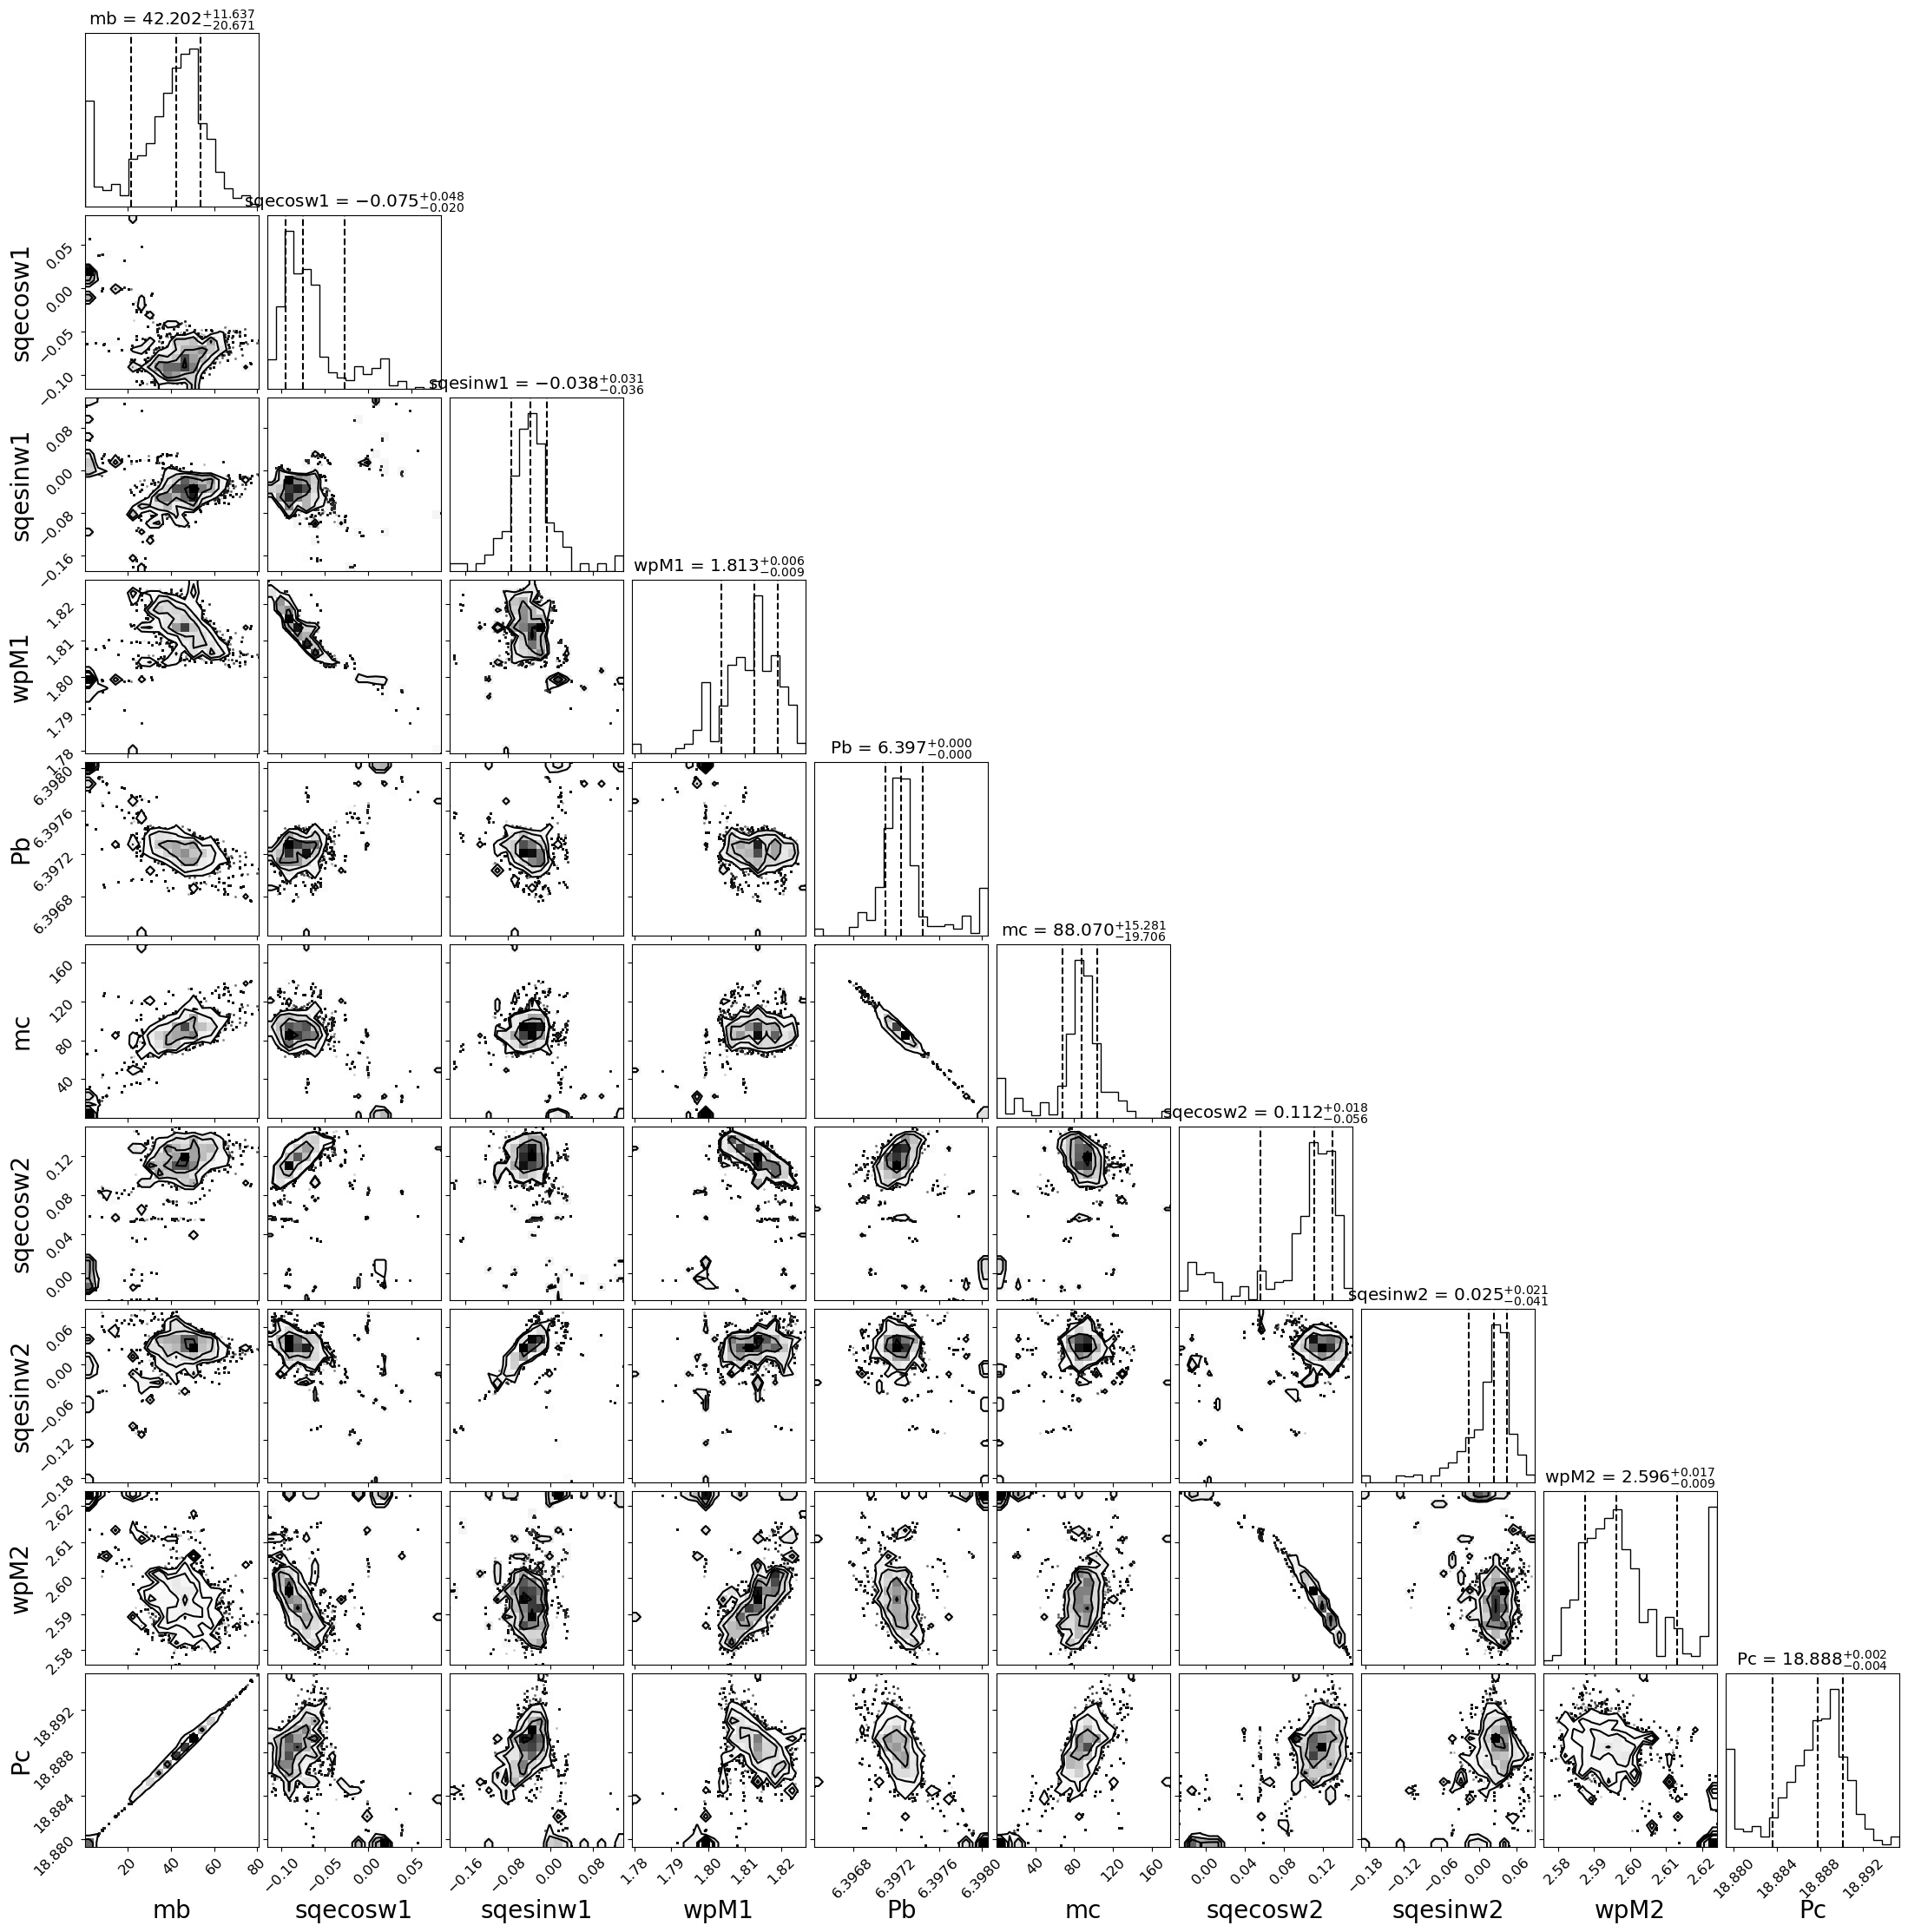

[[2474.13951292 2056.0778937  2049.05269495 ... 2603.86617299
  1078.71665715 1239.15966522]
 [2665.02007437 2648.03411558 2049.05269495 ... 2603.86617299
  2055.84135935 2609.19931082]
 [2665.02007437 2648.03411558 2490.07529709 ... 2603.86617299
  2055.84135935 2632.82437249]
 ...
 [3122.02657414 3123.10094932 3121.66290556 ... 3120.06038965
  3106.34444396 3118.37540185]
 [3122.02657414 3123.10094932 3121.66290556 ... 3120.06038965
  3106.34444396 3118.37540185]
 [3122.02657414 3123.10094932 3121.66290556 ... 3120.06038965
  3106.34444396 3118.37540185]]


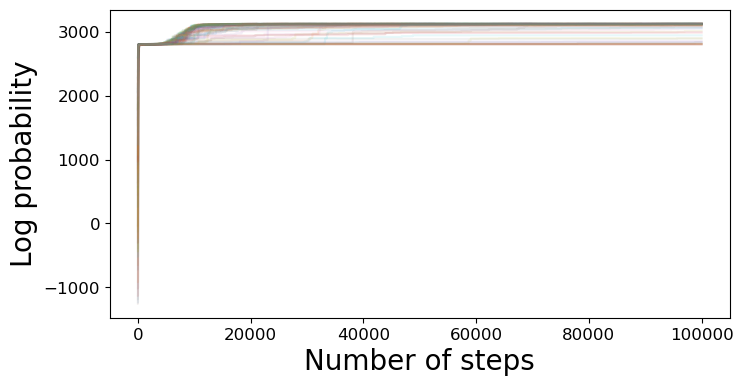

3125.537661121131
[ 5.25996601e+01 -7.36663937e-02 -2.26737288e-02  1.80952282e+00
  6.39721757e+00  9.12521558e+01  1.29494918e-01  3.42059817e-02
  2.58744209e+00  1.88898180e+01]


In [59]:
y=mcmc_first()

100%|█████████████████████████████████████████| 100000/100000 [1:44:47<00:00, 15.91it/s]


48.320651660159484 + 12.589122227472316 - 9.350755047591718
-0.07623653076875225 + 0.0213462043832265 - 0.027003359858640844
-0.030566700891403766 + 0.02060555841916438 - 0.02148880995581432
1.8113386691249365 + 0.008816343131467619 - 0.006081838189519573
6.397232195458676 + 0.00011931449920510317 - 0.00011995065129077886
89.15865410046958 + 12.467996491816749 - 12.796326008274747
0.12507936977430362 + 0.017882968048079068 - 0.02661538378124742
0.03422127921691623 + 0.02132278926134433 - 0.019223469744770502
2.5896358546484266 + 0.010295675113495939 - 0.009137796239360174
18.889002890297512 + 0.002427199521648049 - 0.0018505303897775605


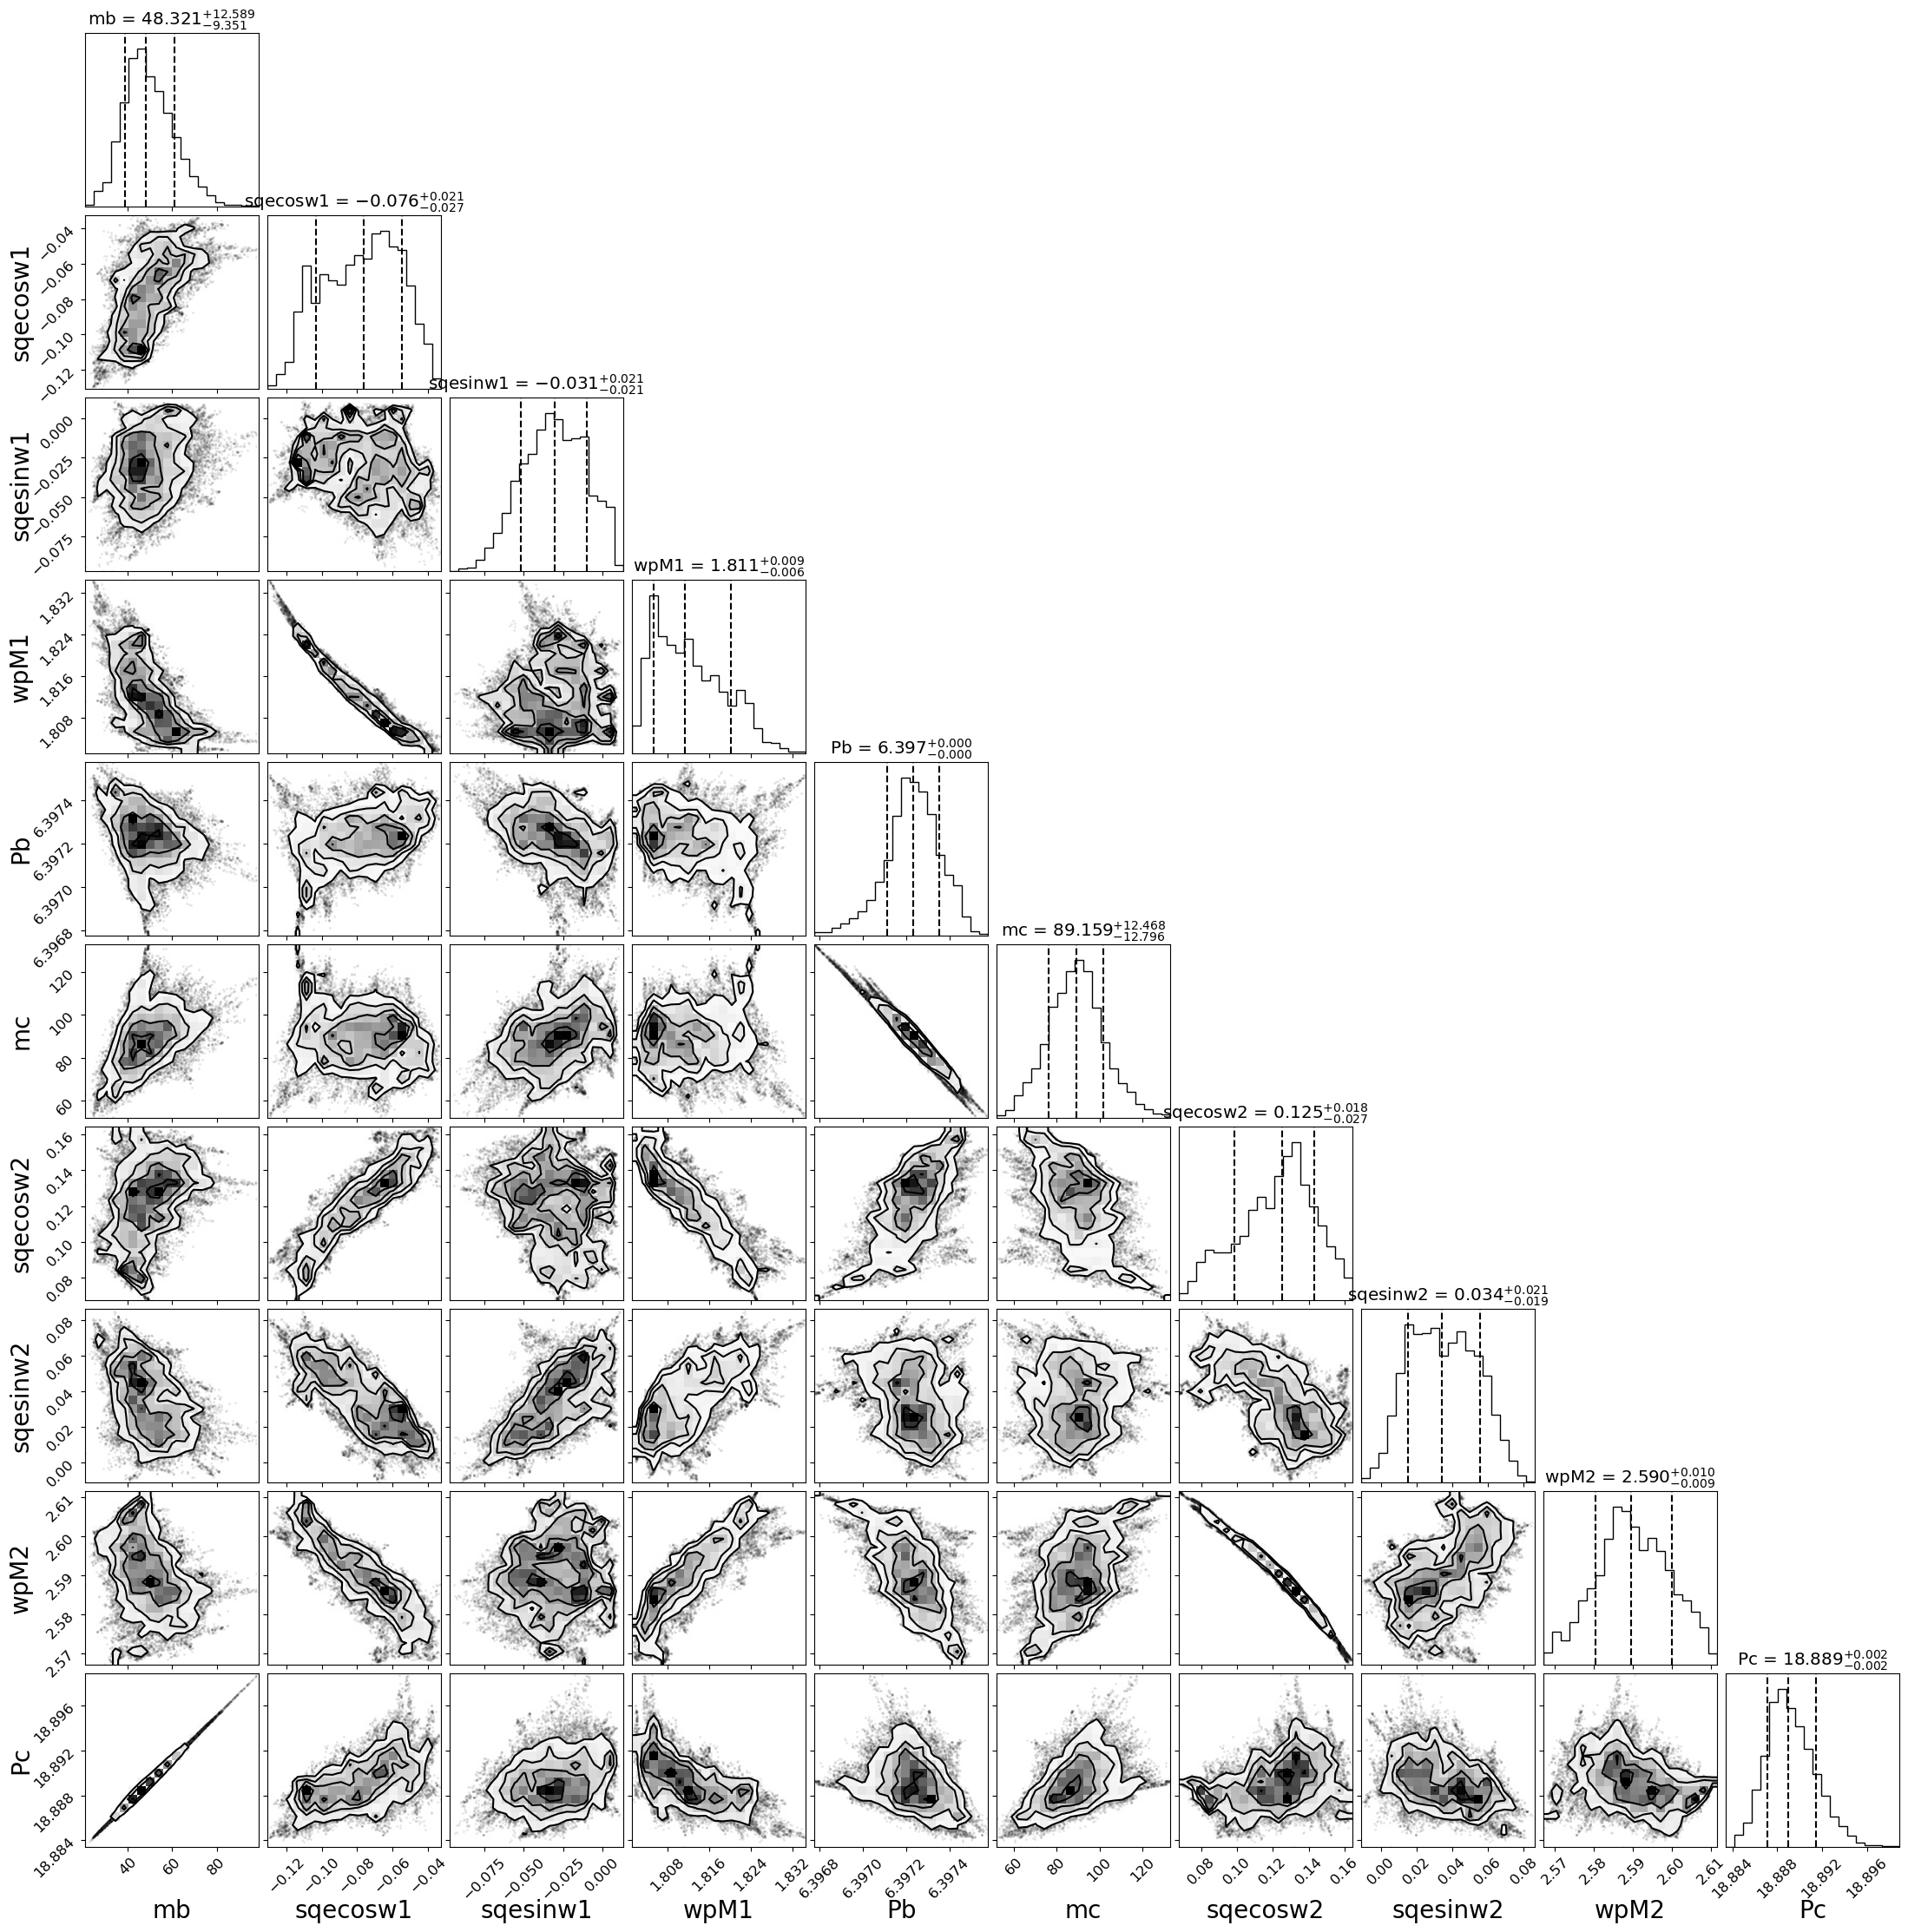

[[3120.48922165 3120.52836707 3120.7512792  ... 3124.22467203
  3124.30556049 3124.60991192]
 [3121.27007643 3120.52836707 3120.7512792  ... 3124.22467203
  3124.30556049 3124.60991192]
 [3121.27007643 3120.52836707 3120.7512792  ... 3123.14618349
  3123.27265113 3124.60991192]
 ...
 [3120.81082508 3122.97839767 3120.9397435  ... 3121.70704093
  3120.04035847 3118.58060153]
 [3120.81082508 3122.97839767 3120.9397435  ... 3121.70704093
  3120.04035847 3118.58060153]
 [3120.81082508 3122.97839767 3121.56572782 ... 3121.70704093
  3120.04035847 3118.58060153]]


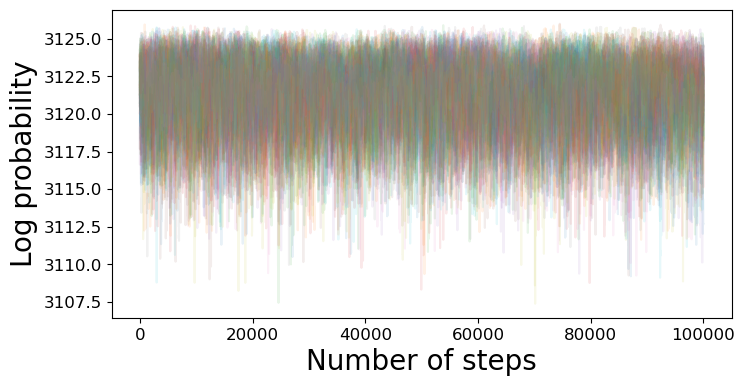

3125.979048373723
[ 5.22821008e+01 -7.40699084e-02 -3.19794706e-02  1.81000684e+00
  6.39720578e+00  9.26411266e+01  1.26673851e-01  3.07098870e-02
  2.58909402e+00  1.88897528e+01]


In [63]:
y=mcmc_second(y)

100%|█████████████████████████████████████████| 100000/100000 [1:36:29<00:00, 17.27it/s]


50.273759130434506 + 13.938854131161158 - 11.989744804145921
-0.07790853078046026 + 0.026145449501947797 - 0.027536398583634616
-0.02762067746094333 + 0.014998500863546475 - 0.020408979569944898
1.8112479802797838 + 0.010280618351084181 - 0.007007262614503018
6.397224714213967 + 9.837308106330767e-05 - 0.00010187812122364193
90.15952399878671 + 10.919834267019425 - 11.216023879352733
0.12194504299686182 + 0.020985998912790266 - 0.022939242091521317
0.03514240390686886 + 0.018099225172326497 - 0.01858889260912592
2.5908334979166323 + 0.009774411287674756 - 0.010285737578353604
18.889361978975984 + 0.0027043785392670827 - 0.002319884546071904


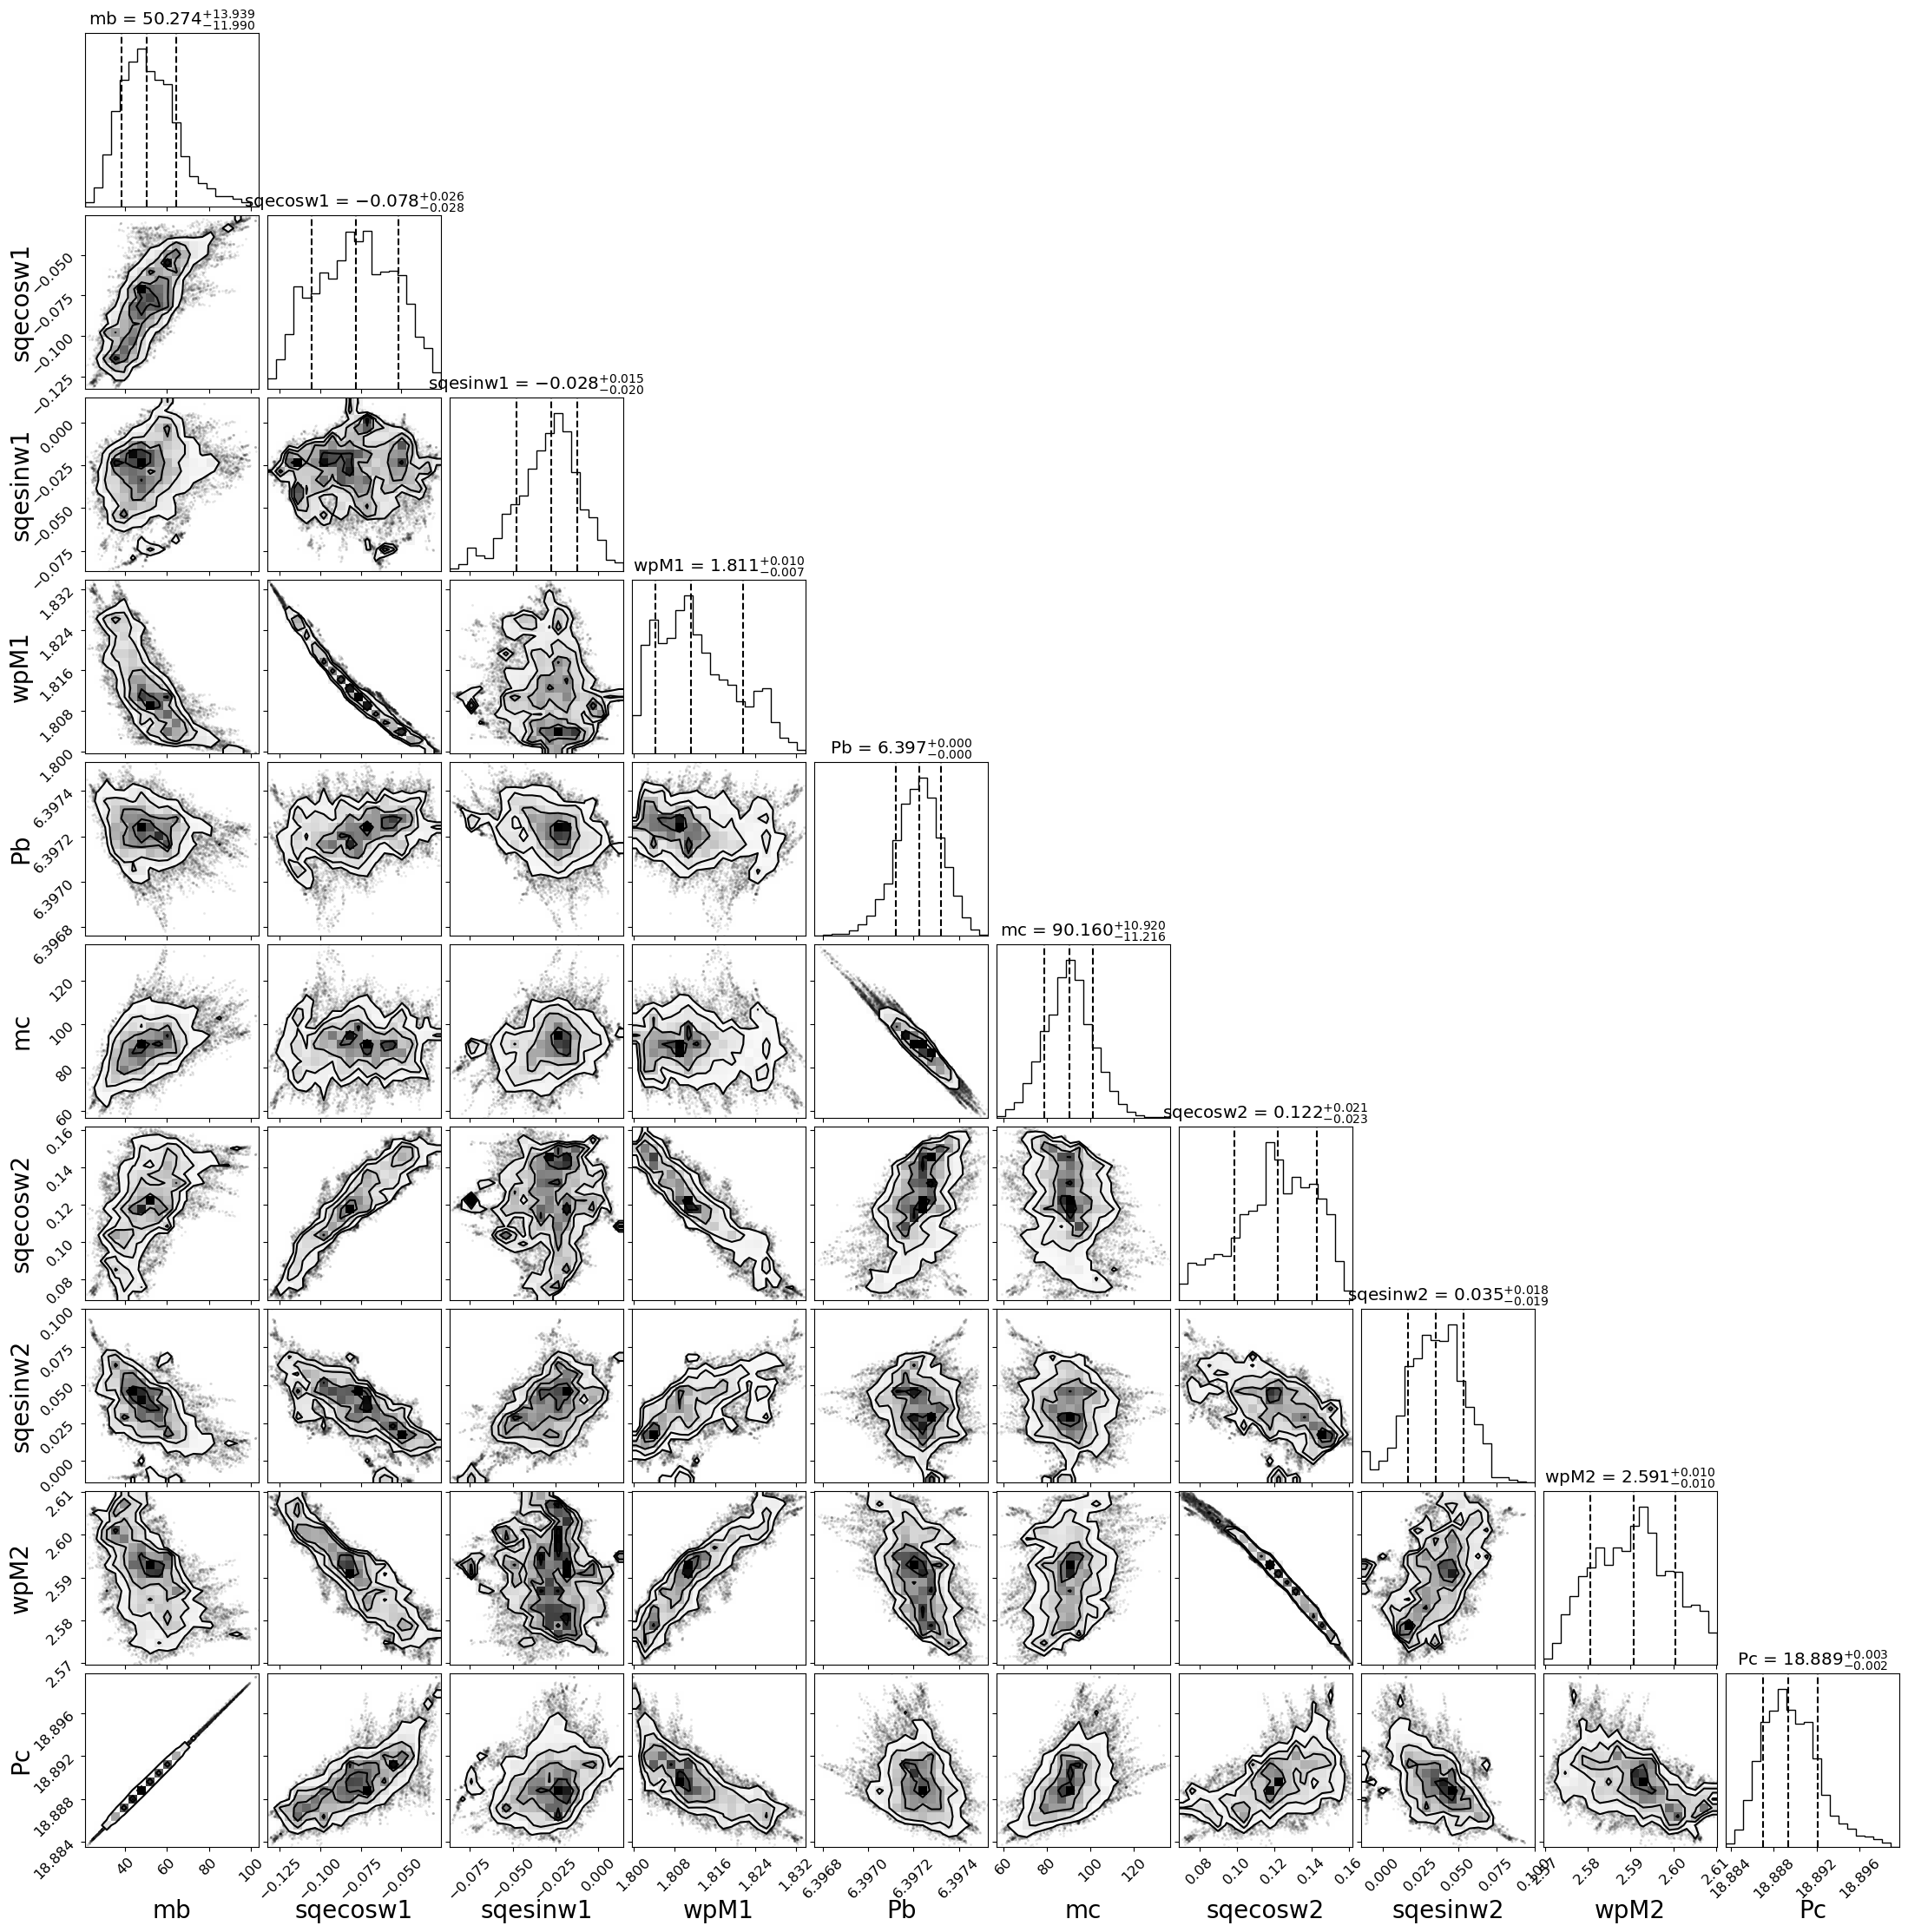

[[3120.81082508 3122.97839767 3121.56572782 ... 3121.70704093
  3120.04035847 3118.58060153]
 [3120.81082508 3122.97839767 3121.56572782 ... 3121.70704093
  3120.04035847 3118.58060153]
 [3122.16864782 3122.97839767 3121.56572782 ... 3123.19585607
  3120.04035847 3118.58060153]
 ...
 [3119.91340122 3122.1167733  3123.76821474 ... 3124.20130307
  3123.60713184 3122.64956953]
 [3119.91340122 3122.1167733  3123.76821474 ... 3124.20130307
  3123.60713184 3122.64956953]
 [3119.91340122 3122.1167733  3123.76821474 ... 3124.20130307
  3123.60713184 3122.64956953]]


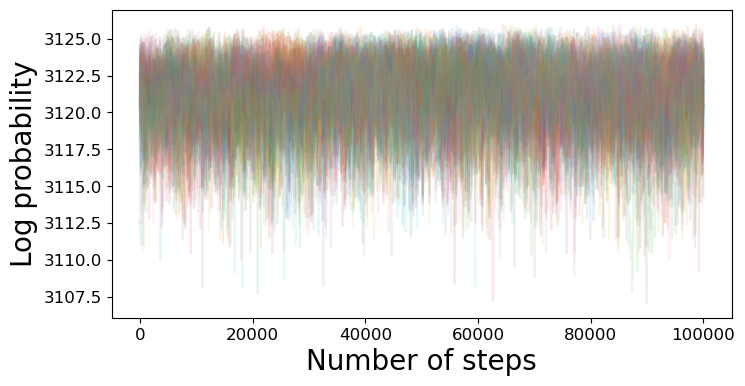

3125.91420217613
[ 5.42605187e+01 -7.18023032e-02 -2.02051069e-02  1.80880934e+00
  6.39721614e+00  9.14723257e+01  1.29870937e-01  3.78423114e-02
  2.58700462e+00  1.88901461e+01]


In [64]:
y=mcmc_second(y)